Attempt to finetune DistilBERT-base-uncased for Arxiv papers multiclassification:
- Prepare dataset
- Tokenize
- Load model
- Define metrics
- Define Trainer object and TrainingArguments
- Evaluate predictions
- Error analysis


In [ ]:
import numpy as np
from datasets import load_from_disk
from transformers import AutoTokenizer
import torch
from transformers import AutoModelForSequenceClassification, Trainer, \
                         TrainingArguments, EarlyStoppingCallback, set_seed

from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report
from src.utils import plot_confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

SEED = 42
set_seed(SEED)

all_stream_data = load_from_disk("data/processed/all_stream_data")


In [73]:
print(all_stream_data)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 72342
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1925
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1926
    })
})


In [74]:
model_id = "allenai/scibert_scivocab_uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=256)


In [75]:
train_dataset = all_stream_data["train"].map(tokenize, batched=True, batch_size=None)

eval_dataset = all_stream_data["validation"].map(tokenize, batched=True, batch_size=None)


In [76]:
labels = all_stream_data["train"].features["label"].names
y_valid = np.array(eval_dataset["label"])


In [77]:
num_labels = len(labels)
model = (AutoModelForSequenceClassification
        .from_pretrained(model_id, num_labels=num_labels)
        .to(device))


In [ ]:
batch_size = 32
num_train_epochs = 4
learning_rate = 2e-5
model_name = f"./models/scibert-finetuned-arxiv-{SEED}"
training_args = TrainingArguments(output_dir=model_name,
                                  overwrite_output_dir=True,
                                  num_train_epochs=num_train_epochs,
                                  learning_rate=learning_rate,
                                  weight_decay=0.01,
                                  warmup_steps=500,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size * 2,
                                  fp16=True,
                                  eval_strategy="steps",
                                  eval_steps=500,
                                  disable_tqdm=False,
                                  logging_strategy="steps",
                                  logging_steps=500,
                                  logging_dir=f"{model_name}/logs",
                                  log_level="error",
                                  report_to="tensorboard",
                                  load_best_model_at_end=True,
                                  metric_for_best_model="macro_f1",
                                  greater_is_better=True,
                                  push_to_hub=False,
                                  label_smoothing_factor=0.1,
                                  save_steps=500,
                                  save_strategy="steps",
                                  save_total_limit=3)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    macro_f1 = f1_score(labels, preds, average="macro")
    balanced_accuracy = balanced_accuracy_score(labels, preds)
    return {"macro_f1": macro_f1, "balanced_accuracy": balanced_accuracy}


In [80]:
# Calculate class weights
train_labels = np.array(train_dataset["label"])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to PyTorch tensor and move to the right device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(model.device)

class CustomTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Apply class weights to the loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss


In [81]:
trainer = CustomTrainer(
    class_weights=class_weights,
    model=model, 
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

trainer.train()


Step,Training Loss,Validation Loss,Macro F1,Balanced Accuracy
500,1.809500,0.933192,0.573093,0.677457
1000,0.851500,0.775516,0.640928,0.756035
1500,0.722900,0.640539,0.640527,0.781275
2000,0.704600,0.670634,0.671924,0.769882
2500,0.630400,0.608063,0.702905,0.797287
3000,0.484200,0.718045,0.693237,0.769900
3500,0.485500,0.564470,0.694689,0.794195
4000,0.494300,0.649030,0.701382,0.787455
4500,0.483000,0.597044,0.699405,0.805857
5000,0.330500,0.604913,0.726133,0.809520


TrainOutput(global_step=8500, training_loss=0.5181996118882123, metrics={'train_runtime': 1247.0316, 'train_samples_per_second': 232.045, 'train_steps_per_second': 7.252, 'total_flos': 3.578365431570432e+16, 'train_loss': 0.5181996118882123, 'epoch': 3.7593984962406015})

In [82]:
preds_output = trainer.predict(eval_dataset)
preds_output.metrics


{'test_loss': 0.6479660868644714,
 'test_macro_f1': 0.7333703895284664,
 'test_balanced_accuracy': 0.8058842764517503,
 'test_runtime': 2.6966,
 'test_samples_per_second': 713.873,
 'test_steps_per_second': 11.496}

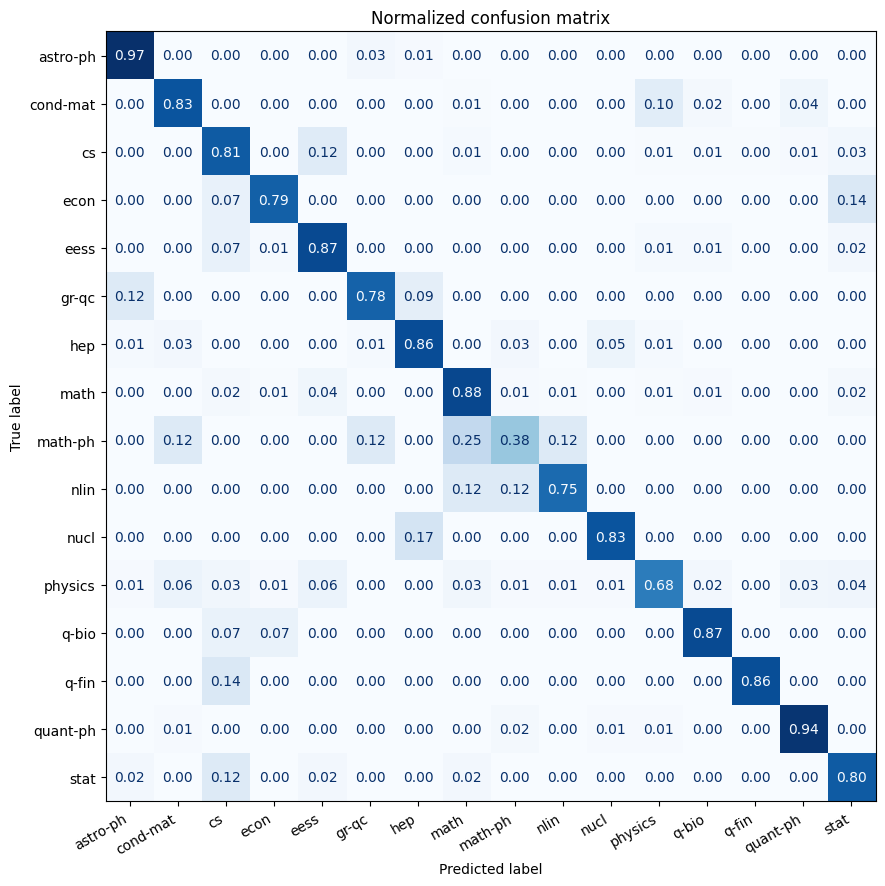

In [83]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)


In [84]:
print(classification_report(y_valid, y_preds, target_names=labels))


              precision    recall  f1-score   support

    astro-ph       0.94      0.97      0.95       120
    cond-mat       0.90      0.83      0.86       137
          cs       0.96      0.81      0.88       818
        econ       0.69      0.79      0.73        14
        eess       0.39      0.87      0.54        84
       gr-qc       0.83      0.78      0.81        32
         hep       0.91      0.86      0.88        79
        math       0.93      0.88      0.90       331
     math-ph       0.25      0.38      0.30         8
        nlin       0.60      0.75      0.67         8
        nucl       0.71      0.83      0.77        18
     physics       0.77      0.68      0.72       123
       q-bio       0.45      0.87      0.59        15
       q-fin       0.55      0.86      0.67         7
    quant-ph       0.83      0.94      0.88        90
        stat       0.45      0.80      0.58        41

    accuracy                           0.83      1925
   macro avg       0.70   

In [85]:
test_dataset = all_stream_data["test"].map(
    tokenize, batched=True, batch_size=None
)
preds_output = trainer.predict(test_dataset)
preds_output.metrics


{'test_loss': 0.7222564220428467,
 'test_macro_f1': 0.7566054657899688,
 'test_balanced_accuracy': 0.8138293074945462,
 'test_runtime': 2.9036,
 'test_samples_per_second': 663.318,
 'test_steps_per_second': 10.676}

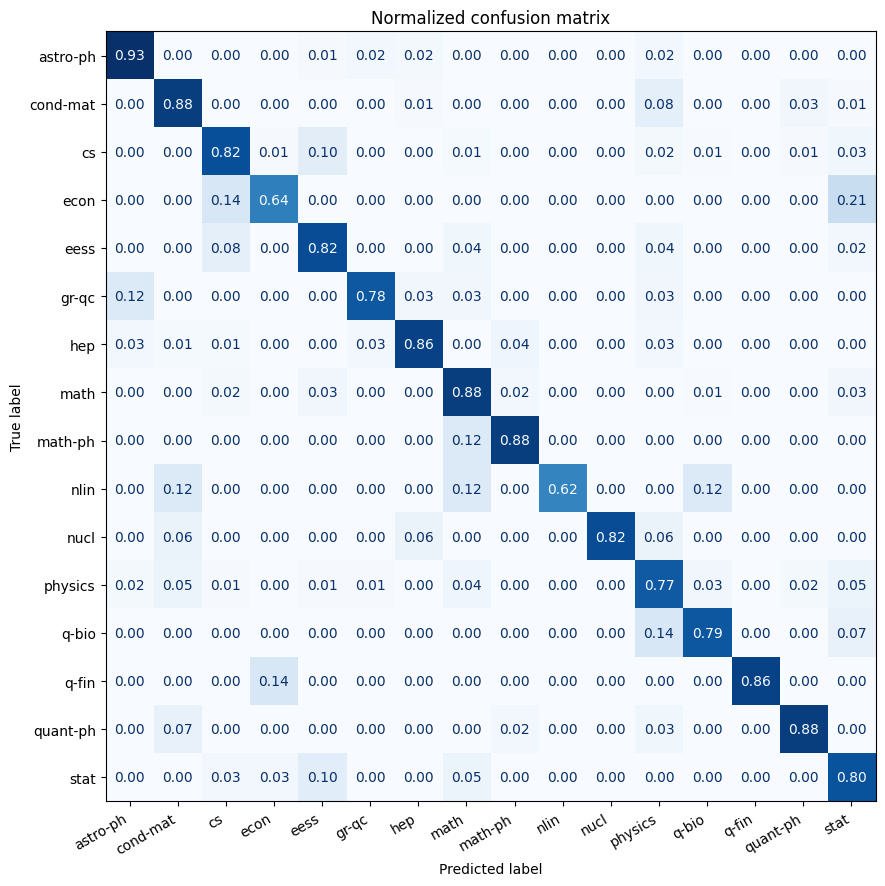

In [86]:
y_test = np.array(test_dataset["label"])
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_test, labels)


In [87]:
print(classification_report(y_test, y_preds, target_names=labels))


              precision    recall  f1-score   support

    astro-ph       0.93      0.93      0.93       121
    cond-mat       0.88      0.88      0.88       137
          cs       0.97      0.82      0.89       819
        econ       0.53      0.64      0.58        14
        eess       0.43      0.82      0.56        85
       gr-qc       0.78      0.78      0.78        32
         hep       0.93      0.86      0.89        79
        math       0.92      0.88      0.90       331
     math-ph       0.35      0.88      0.50         8
        nlin       0.83      0.62      0.71         8
        nucl       1.00      0.82      0.90        17
     physics       0.70      0.77      0.74       124
       q-bio       0.48      0.79      0.59        14
       q-fin       0.86      0.86      0.86         7
    quant-ph       0.86      0.88      0.87        90
        stat       0.39      0.80      0.52        40

    accuracy                           0.84      1926
   macro avg       0.74   

In [3]:
from huggingface_hub import notebook_login
notebook_login()


In [5]:
model_path = "models/scibert-finetuned-arxiv-42/checkpoint-6000"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)


In [6]:
model.push_to_hub("gpham/scibert-finetuned-arxiv-42")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gpham/scibert-finetuned-arxiv-42/commit/1ca568904e942895a2ae6ba46fd937fce9a20fbf', commit_message='Upload BertForSequenceClassification', commit_description='', oid='1ca568904e942895a2ae6ba46fd937fce9a20fbf', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gpham/scibert-finetuned-arxiv-42', endpoint='https://huggingface.co', repo_type='model', repo_id='gpham/scibert-finetuned-arxiv-42'), pr_revision=None, pr_num=None)

In [7]:
tokenizer.push_to_hub("gpham/scibert-finetuned-arxiv-42")


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gpham/scibert-finetuned-arxiv-42/commit/5559c96802aa590b1541a1fad79da7aeb4e91421', commit_message='Upload tokenizer', commit_description='', oid='5559c96802aa590b1541a1fad79da7aeb4e91421', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gpham/scibert-finetuned-arxiv-42', endpoint='https://huggingface.co', repo_type='model', repo_id='gpham/scibert-finetuned-arxiv-42'), pr_revision=None, pr_num=None)